## 1️⃣ [Week3/심화] Multi-genre natural language inference(MNLI)

MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제입니다.

* data : https://www.kaggle.com/datasets/thedevastator/unlocking-language-understanding-with-the-multin

### 1. 데이터 불러오기

In [14]:
import random
import pandas as pd

train_df = pd.read_csv('./train.csv', on_bad_lines="skip")
test_df = pd.read_csv('./validation_matched.csv', on_bad_lines="skip")

print("** train **")
print(f"train len : {len(train_df)}")
print(train_df.columns)
print("** test **")
print(f"test len : {len(test_df)}")

** train **
train len : 392702
Index(['promptID', 'pairID', 'premise', 'premise_binary_parse',
       'premise_parse', 'hypothesis', 'hypothesis_binary_parse',
       'hypothesis_parse', 'genre', 'label'],
      dtype='object')
** test **
test len : 9815


#### 📋 MNLI 데이터셋 칼럼 설명
|칼럼 이름|설명|
|--|--|
|promptID	|원본 문서나 문단 단위의 ID. |
|pairID|	각 문장 쌍의 고유 식별자.|
|premise	|전제 문장.|
|premise_binary_parse	|전제 문장의 binary constituency 구문 트리 (문법 구조 파싱 결과, 괄호로 표현됨).|
|premise_parse	|전제 문장의 full constituency 구문 트리. |
|hypothesis	|가설 문장. premise를 기반으로 이 문장이 참인지 아닌지를 판단|
|hypothesis_binary_parse|	가설 문장의 binary 구문 트리.|
|hypothesis_parse	|가설 문장의 full constituency 구문 트리.|
|genre	|문장 쌍이 나온 도메인/장르 (예: fiction, slate, telephone, travel, government 등). 모델이 도메인 일반화 능력을 가질 수 있게 도와주는 요소.|
|label|	정답 레이블. entailment, contradiction, neutral, 또는 - (레이블 없음: 예측 대상일 때 사용).|

결굴 premise와 hypothesis의 관계를 pred 해야하는 것이고 정답은 label에 있으므로 이 3개 column을 사용하면 된다.

##### 데이터 확인 및 전처리

* 결측치 확인
* train 데이터 분포 확인 (불균형한지)
* label의 의미 확인

In [15]:
train_df = train_df[['premise','hypothesis','label']]
test_df = test_df[['premise','hypothesis','label']]
train_df.head()

,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1


In [16]:


print("** train **")
print(train_df.isnull().sum())
print("** test **")
print(test_df.isnull().sum())


** train **
premise        0
hypothesis    40
label          0
dtype: int64
** test **
premise       0
hypothesis    0
label         0
dtype: int64


In [17]:
## 결측치 제거
before_len = len(train_df)
train_df = train_df.dropna()
after_len = len(train_df)

print(f"{before_len - after_len} rows dropped.")

40 rows dropped.


In [18]:
train_df['label'].unique()

array([1, 0, 2])

train data가 불균형한지도 확인해준다.

In [19]:
train_df['label'].value_counts()

label
2    130889
1    130887
0    130886
Name: count, dtype: int64

In [20]:
for label in train_df['label'].unique():
    examples = train_df[train_df['label'] == label].sample(3)
    print(f"\nLabel {label} 예시:")
    for i, row in examples.iterrows():
        print(f"- Premise: {row['premise']}")
        print(f"  Hypothesis: {row['hypothesis']}")


Label 1 예시:
- Premise: money that you can touch but it's tax deferred and yields a higher rate in general than what we can get in CD's and gets life it's a it's a term life policy also
  Hypothesis: It's tax deferred, so you can touch it, but it yields a higher rate in general and looks better on your tax report.
- Premise: The scenic coastal circuit begins (and ends) in Manfredonia, with historical attractions such as the 12th-century church of Santa Maria di Siponto (southwest of town), but tourism here is generally of the sun-and-sea kind, as it is one of Italy's most attractive natural regions.
  Hypothesis: The church gets thousands of dollars each month in money from tourism.
- Premise: He made major contributions to the development of the International Organization of Supreme Audit Institutions (INTOSAI), which includes 179 countries, and he also created an international fellows program at GAO to provide support, training, and guidance to a cadre of key individuals from account

어떤 라벨이 어떤 뜻인지 헷갈렸는데 예시 찍어보고 다시 확인

* label 0 - Entailment
  * 의미가 거의 같거나, 하나가 다른 하나로부터 도출됨
* label 1 - Neutral
* Label 2 - Contradiction
  * 전제와 가설이 명백히 상반됨

### 2. dataset 준비

* tokenizer 불러오기
* dataset 만들기
* collate_fn 안에서 여러 처리


In [21]:
from transformers import AutoTokenizer

def get_tokenizer(model_name):
    return AutoTokenizer.from_pretrained(model_name)

/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from torch.utils.data import Dataset

class Dataset_Maker(Dataset):
    def __init__(self, df):
        self.pairs = list(zip(df['premise'], df['hypothesis']))
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text_pair': self.pairs[idx],
            'label': self.labels[idx]
        }

* collate_fn
  * premises와 hypotheses를 한 문장 쌍으로 만듬
  * 패딩 처리
  * truncation 처리
  * masking은 attention_mask 사용

In [23]:
import torch

def collate_fn(batch, tokenizer, max_length=256):
    premises, hypotheses = zip(*[item['text_pair'] for item in batch])
    labels = [item['label'] for item in batch]

    encodings = tokenizer(
        list(premises),
        list(hypotheses),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    encodings['labels'] = torch.tensor(labels, dtype=torch.long)
    return encodings

In [24]:
model_name = "distilbert-base-uncased"

In [38]:
from torch.utils.data import DataLoader

tokenizer = get_tokenizer(model_name)

def get_dataloader(tokenizer, train_df, test_df, batch_size):
    max_length = tokenizer.model_max_length

    train_ds = Dataset_Maker(train_df)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length)
    )

    test_ds = Dataset_Maker(test_df)
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length)
    )
    return train_loader, test_loader

train_loader, test_loader = get_dataloader(tokenizer, train_df, test_df, 64)

### 3. Model 구성
* pretrained model 불러오기
* MNLIClassifier 구조잡기

In [39]:
import torch.nn as nn
from transformers import AutoModel

In [40]:
class MNLIClassifier(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.pretrained_model = AutoModel.from_pretrained(model_name)
        hidden_size = self.pretrained_model.config.hidden_size

        self.classifier = nn.Linear(hidden_size, 3)


    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS 위치
        pred_output = self.classifier(cls_output)
        return pred_output


In [41]:
model = MNLIClassifier(model_name)

In [42]:
print(model)

MNLIClassifier(
  (pretrained_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [43]:
for param in model.pretrained_model.parameters():
    param.required_grad=False

### 4. finetuning

In [44]:
def evaluate_acc(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct/total

In [45]:
def model_eval(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_count = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = nn.functional.cross_entropy(logits, labels)

            preds = logits.argmax(dim=1)
            acc = evaluate_acc(preds, labels)

            total_loss += loss.item()
            total_acc += acc * labels.size(0)
            total_count += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc


In [46]:
def model_train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs):
    device = 'cuda'
    loss_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            preds = model(input_ids, attention_mask)

            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss

        val_loss, val_acc = model_eval(model, test_loader, device)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        loss_list.append(train_loss)
        test_acc_list.append(val_acc)
    return loss_list, test_acc_list


In [47]:
from torch.optim import Adam, AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [48]:
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 3

loss_list, test_acc = model_train(model, train_loader, test_loader, optimizer, loss_fn, n_epochs)

Epoch 1/3:   0%|          | 2/6136 [00:00<11:34,  8.83it/s]

Epoch 1/3: 100%|██████████| 6136/6136 [12:26<00:00,  8.21it/s]


[Epoch 1] Train Loss: 6756.5390 | Val Loss: 1.0979 | Val Acc: 0.3545


Epoch 2/3: 100%|██████████| 6136/6136 [12:29<00:00,  8.19it/s]


[Epoch 2] Train Loss: 6744.9083 | Val Loss: 1.0994 | Val Acc: 0.3274


Epoch 3/3: 100%|██████████| 6136/6136 [12:35<00:00,  8.13it/s]


[Epoch 3] Train Loss: 6743.2022 | Val Loss: 1.0985 | Val Acc: 0.3545


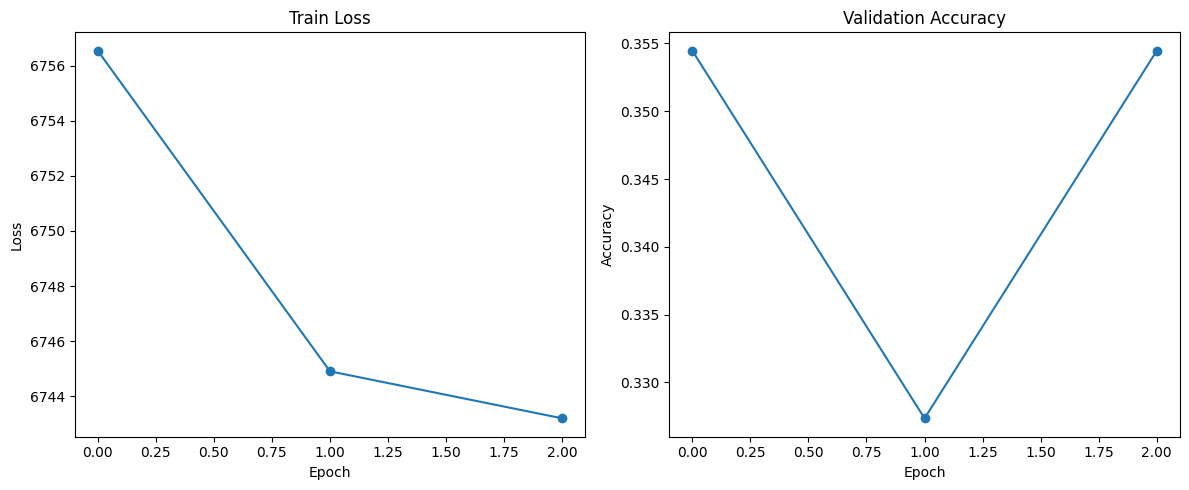

In [51]:
plot_loss_accuracy(loss_list, test_acc)

##### plot
* plot_loss_accuracy
* compare_accuracy

In [49]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss_list, acc_list):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_list, marker='o')
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(acc_list, marker='o')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


In [61]:
def compare_accuracy(acc_list_1, acc_list_2, label1="Model 1", label2="Model 2"):
    epochs = range(1, len(acc_list_2) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc_list_1, marker='o', label=label1)
    plt.plot(epochs, acc_list_2, marker='o', label=label2)
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [67]:
def plot_first_value(list1, list2, label1, label2):
    value1 = list1[0]
    value2 = list2[0]

    plt.bar([label1, label2], [value1, value2])
    plt.ylabel('value')
    plt.title('acc comparison')
    plt.ylim(0, max(value1, value2) * 1.2)

    for i, v in enumerate([value1, value2]):
        plt.text(i, v+0.01, f'{v:.3f}', ha='center')

    plt.show()

---
#### 변형 1
* lr 낮추기
* dropout 추가

In [52]:
class MNLIClassifierWithDropout(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.pretrained_model = AutoModel.from_pretrained(model_name)
        hidden_size = self.pretrained_model.config.hidden_size

        self.classifier = nn.Linear(hidden_size, 3)
        self.dropout = nn.Dropout(0.1)

        print(f"** load pretrained model {model_name} **")
        print(self.pretrained_model)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS 위치
        cls_output = self.dropout(cls_output)
        pred_output = self.classifier(cls_output)
        return pred_output


In [53]:
model2 = MNLIClassifierWithDropout(model_name)
model2 = model2.to('cuda')

** load pretrained model distilbert-base-uncased **
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=76

In [54]:
for param in model2.pretrained_model.parameters():
    param.required_grad=False

In [55]:
lr = 2e-5
optimizer = Adam(model2.parameters(), lr=lr)
n_epochs = 3

loss_list_2, test_acc_2 = model_train(model2, train_loader, test_loader, optimizer, loss_fn, n_epochs)

Epoch 1/3: 100%|██████████| 6136/6136 [12:29<00:00,  8.19it/s]


[Epoch 1] Train Loss: 3661.7596 | Val Loss: 0.4942 | Val Acc: 0.8047


Epoch 2/3: 100%|██████████| 6136/6136 [12:35<00:00,  8.12it/s]


[Epoch 2] Train Loss: 2686.7961 | Val Loss: 0.4799 | Val Acc: 0.8118


Epoch 3/3: 100%|██████████| 6136/6136 [12:39<00:00,  8.08it/s]


[Epoch 3] Train Loss: 2095.9718 | Val Loss: 0.5055 | Val Acc: 0.8133


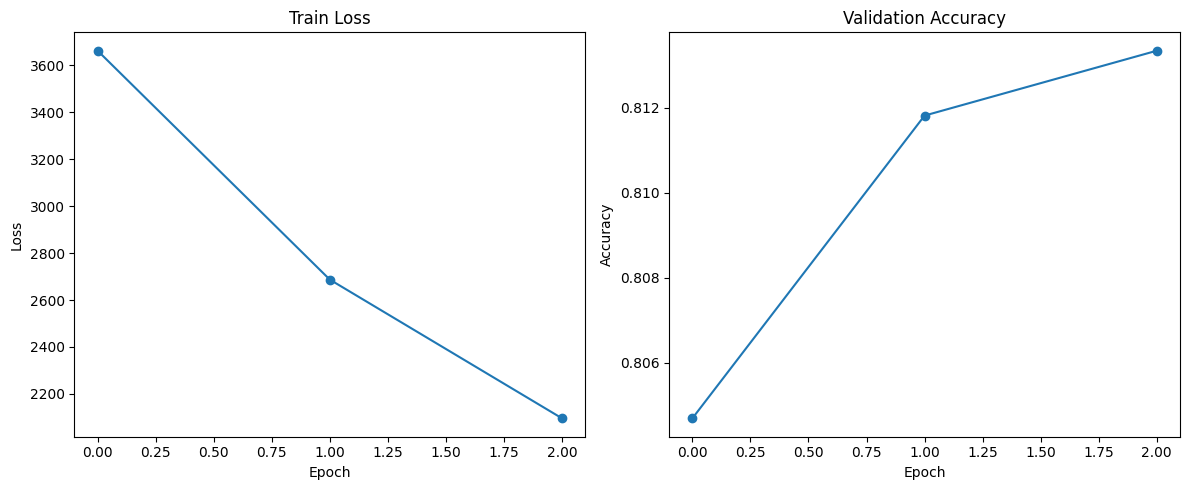

In [56]:
plot_loss_accuracy(loss_list_2, test_acc_2)

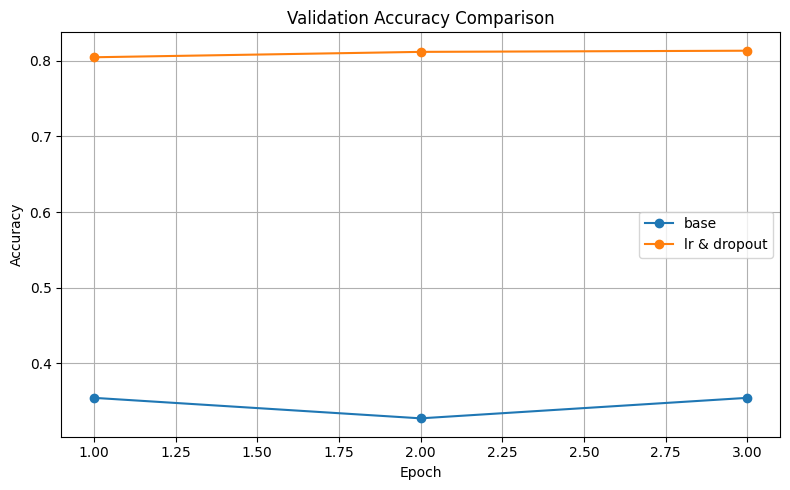

In [57]:
compare_accuracy(test_acc, test_acc_2, "base", "lr & dropout")

너무 드라마틱하게 성능이 올라가서 둘 중 어떤 영향인지 알고 싶음. epoch당 성능 증가가 크지 않으니 1epoch으로 나머지 실험을 해보고자 한다.

##### 1. learning rate만 수정

In [59]:
model3 = MNLIClassifier(model_name)
model3 = model3.to('cuda')
for param in model3.pretrained_model.parameters():
    param.required_grad=False

lr = 2e-5
optimizer = Adam(model3.parameters(), lr=lr)
n_epochs = 1

loss_list_3, test_acc_3 = model_train(model3, train_loader, test_loader, optimizer, loss_fn, n_epochs)

Epoch 1/1:   0%|          | 1/6136 [00:00<13:52,  7.37it/s]

Epoch 1/1: 100%|██████████| 6136/6136 [12:37<00:00,  8.10it/s]


[Epoch 1] Train Loss: 3669.3191 | Val Loss: 0.4995 | Val Acc: 0.8015


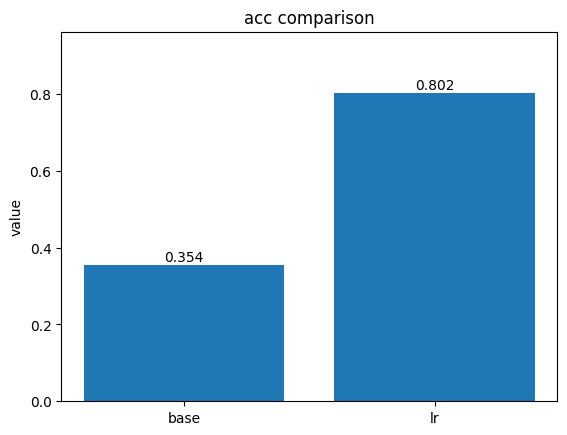

In [68]:
plot_first_value(test_acc, test_acc_3, "base", "lr")

- **결론**   
  learning rate만 수정해도 성능이 대폭 늘어나는 걸 볼 수 있었다.

- **추가**   
  나중에 찾아보니 finetune 할때 learning rate는 작게 하는 것이 더 유리하다고 한다.
  1. 사전 학습된 지식 보전을 위해
  2. 파라미터가 이미 좋은 위치에 있기 때문에
  3. lr이 크면 loss가 널뛰기하거나 발산할 위험이 크기 때문에
